<a href="https://colab.research.google.com/github/da2985/e6885-adnet/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Please use the following two lines to load from Google Drive

If your file is not there, upload it to https://drive.google.com/drive/folders/1tsPKyB2E1nW8Qw--kZ9GaeGW2u2-XoV6?usp=sharing

In [ ]:
# This must be run within a Google Colab environment 
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
import os

sys.path.append('/content/gdrive/EE6885')

os.chdir("/content/gdrive/My Drive/EE6885")

### LOOK FOR AVAILABLE DATASETS IN THE FOLLOWING CELL. DO NOT DELETE

In [ ]:
!ls adnet_datasets/OTB

 Basketball   Car1	 Deer	      Human3	 Mhyang         Soccer
 Biker	      Car2	 Dog	      Human4	 MotorRolling   Subway
 Bird1	      Car24	 Dog1	      Human5	 MountainBike   Surfer
 Bird2	      Car4	 Doll	      Human6	 Panda	        Suv
 BlurBody     CarDark	 DragonBaby   Human7	 RedTeam        Sylvester
 BlurCar1     CarScale	 Dudek	      Human8	 Rubik	        Tiger1
 BlurCar2     ClifBar	 FaceOcc1     Human9	 Shaking        Tiger2
 BlurCar3     Coke	 FaceOcc2     Ironman	 Singer1        Toy
 BlurCar4     Couple	 Fish	      Jogging	 Singer2        Trans
 BlurFace     Coupon	 FleetFace    Jump	 Skater         Trellis
 BlurOwl      Crossing	 Football1    Jumping	 Skater2        Twinnings
 Board	      Crowds	 Freeman1     KiteSurf	'Skater2 (1)'   Vase
 Bolt	      Dancer	 Girl	      Lemming	 Skating1       Walking
 Bolt2	      Dancer2	 Girl2	      Liquor	 Skating2       Walking2
 Box	      David2	 Gym	      Man	 Skating3       Woman
 Boy	      David3	 Human2       Matrix	 Skiing


In [ ]:
pip install hdf5storage

In [ ]:
import numpy as np
import tensorflow as tf

import cv2
import glob
import hdf5storage
import random
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.patches as patches

from typing import Tuple

import scipy.io as sio
from utils import*

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
 %load_ext autoreload 
 %autoreload 2

# MODEL DEFINITIONS

In [ ]:
class ADNET(tf.keras.Model):
    def __init__(self):
        super(ADNET, self).__init__()

        self.action_history = tf.keras.layers.Input(shape = (1,1,110))

        self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (7, 7), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_1')
        self.max1  = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (1, 1), padding = 'VALID')
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_2')
        self.max2  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (2, 2), padding = 'VALID')
        self.conv3 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_3')
        self.max3  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (1, 1), padding = 'VALID')
        
        self.fc1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'VALID', activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (1,1), padding = 'VALID', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Conv2D(filters = 11, kernel_size = (1,1), padding = 'VALID', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Conv2D(filters = 2, kernel_size = (1,1), padding = 'VALID', name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(0)
        self.dropout2=tf.keras.layers.Dropout(0)
        

    def build(self, action_history):
      super(ADNET, self).build((None, 112, 112, 3))
      self.action_history=action_history

    def setActionHistory(self, action_history):
      self.action_history=action_history

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

    def callForAction(self, input_tensor, training=False):
      '''
      Wrapper action for model.call() to only output action probabilities.
      For RL purposes, this is the only relevant output (as of 12/2/2021).
      '''
      return self.call(input_tensor, training)[0]

    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def getEmbedding(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        return tf.reshape(x,(-1,))

    def getFC1(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.fc1(x)
        return x
      
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

def setWeights(model, weights, weights2):
  model.layers[0].set_weights([weights2["conv1f"],tf.reshape(weights2["conv1b"],(96,))])
  model.layers[2].set_weights([weights2["conv2f"],tf.reshape(weights2["conv2b"],(256,))])
  model.layers[4].set_weights([weights2["conv3f"],tf.reshape(weights2["conv3b"],(512,))])
  
  model.layers[6].set_weights([weights["fc4f"],tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"],tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"],tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"],tf.zeros(2)])
  
  return model

In [ ]:
class ADNET_v2(tf.keras.Model):
    def __init__(self):
        super(ADNET_v2, self).__init__()

        #self.action_history = tf.keras.layers.Input(shape = (1,1,110))
        self.action_history = tf.keras.layers.Input(shape = (110))

        self.resnet=tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling="max")
        #self.resnet = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling=None)
        #self.conv1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (4,4), padding = 'VALID', name = 'fc4',activation="relu")
        
        self.fc1 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform',activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Dense(11,kernel_initializer='glorot_uniform', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Dense(2,kernel_initializer='glorot_uniform',name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(0)
        self.dropout2=tf.keras.layers.Dropout(0)
        

    def build(self, action_history):
      super(ADNET_v2, self).build((None, 112, 112, 3))
      self.action_history=action_history
      self.resnet.trainable = False

    def setActionHistory(self, action_history):
      self.action_history=action_history

    def call(self, input_tensor, training=False):
        x = self.resnet(input_tensor)
        #x = self.conv1(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

    def callForAction(self, input_tensor, training=False):
      '''
      Wrapper action for model.call() to only output action probabilities.
      For RL purposes, this is the only relevant output (as of 12/2/2021).
      '''
      return self.call(input_tensor, training)[0]

    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

# HELPER FUNCTIONS

(array([171, 128,  99, 316]), 10)

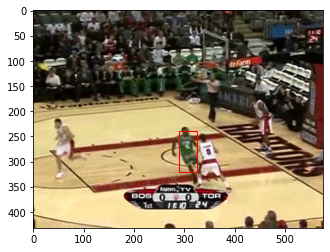

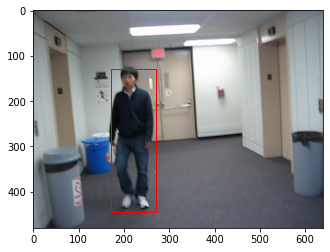

In [40]:
# DEBUGGING helper functions for accessing getting ground truth and image files

def human_readable_action(index: int) -> str:
  '''
  Map action numbers to human readable strings
  '''
  if index == 0:
    return "left"
  elif index == 1:
    return "2x left"
  elif index == 2:
    return "right"
  elif index == 3:
    return "2x right"
  elif index == 4:
    return "down"
  elif index == 5:
    return "2x down"
  elif index == 6:
    return "up"
  elif index == 7:
    return "2x up"
  elif index == 8:
    return "stop"
  elif index == 9:
    return "scale down"
  elif index == 10 :
    return "scale up"


def get_ground_truths(ground_truth_file: str) -> np.array:
  '''
  Use me to convert a ground_truth_file to a numpy array
  '''
  with open(ground_truth_file) as f:
    ground_truths = f.readlines()
    to_nparray = lambda s: np.array(re.findall('\d+', s), dtype=int)
    truths = list(map(to_nparray, ground_truths))
    return np.asarray(truths)
  return None

def plotNpImageBBox(img: np.array, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x, y, w, h = bbox
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.imshow(img)
  return bbox

def plotNpImageBBoxes(img: np.array, src_bbox: np.array, target_bbox: np.array, 
                      pred_bbox: np.array) -> np.array:
  '''
  Plots the bounding boxes on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x1, y1, w1, h1 = src_bbox
  x2, y2, w2, h2 = target_bbox
  x3, y3, w3, h3 = pred_bbox
  rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=1, edgecolor='b', facecolor='none')
  rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=1, edgecolor='r', facecolor='none')
  rect3 = patches.Rectangle((x3, y3), w3, h3, linewidth=1, edgecolor='g', facecolor='none')
  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_patch(rect3)
  plt.imshow(img)
  return bbox  

def plotImageBBox(img: str, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image (from given filepath) and returns the 
  bounding box
  '''
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plotNpImageBBox(img, bbox)
  return bbox

def plotDatasetImageBBox(dataset: str, frame_no: int) -> Tuple[np.array, int]:
  '''
  Plot an image's bounding box. Returns the ground truth and frame number.
  WORKS FOR OTB100
  '''
  imgs = sorted(glob.glob("{0}/img/*".format(dataset)))
  gt = get_ground_truths("{0}/groundtruth_rect.txt".format(dataset))
  plotImageBBox(imgs[frame_no], gt[frame_no])
  return gt[frame_no], frame_no


plotDatasetImageBBox("adnet_datasets/OTB/Basketball", 50)
plotDatasetImageBBox("adnet_datasets/OTB/BlurBody", 10)

In [ ]:
# MOVEMENT helper functions

ALPHA = 0.3 # See p. 4 of the paper
STOP_ACTION_INDEX = 8

def move(image: np.array, bbox: np.array, action: str, 
         stride_magnitude: int=1) -> np.array:
  '''
  Returns the new bounding box after taking an action: 
  {"left", "right", "up", "down"}. Use stride to indicate the step size.
  '''
  if action not in set(["left", "right", "up", "down"]):
    raise RuntimeError("Invalid action taken :(") 
  
  x, y, w, h = bbox
  if action in set(["left", "right"]):
    # Horizontal movement
    step = int(ALPHA * w * stride_magnitude) * (-1 if action=="left" else 1)
    x = x + step if 0 <= x + step < image.shape[1]-w else x
  else:
    # Vertical movement
    step = int(ALPHA * h * stride_magnitude) * (-1 if action=="up" else 1)
    y = y + step if 0 <= y + step < image.shape[0]-h else y

  return np.array([x, y, w, h])

def selectAction(img: np.array, bbox: np.array, action_probs: np.array):
  #index = np.argmax(action_probs)  # TODO: Change to tensorflow argmax? let's check in
  index=tf.math.argmax(action_probs)
  
  if index == 0 :
    bbox = move(img, bbox, "left")
  elif index == 1 :
    bbox = move(img, bbox, "left", stride_magnitude=2)
  elif index == 2 :
    bbox = move(img, bbox, "right")
  elif index == 3 :
    bbox = move(img, bbox, "right", stride_magnitude=2)  
  elif index == 4 :
    bbox = move(img, bbox, "down")  
  elif index == 5 :
    bbox = move(img, bbox, "down", stride_magnitude=2)
  elif index == 6 :
    bbox = move(img, bbox, "up")
  elif index == 7 :
    bbox = move(img, bbox, "up", stride_magnitude=2)
  # Skip index 8, does nothing
  elif index == 9 :
    bbox = scaleDown(bbox, img)  
  elif index == 10 :
    bbox = scaleUp(bbox, img)  
  return index, bbox

def isStop(action: int):
  return action == STOP_ACTION_INDEX

Original bounding box
[161  37  54 170]
Left-shifted bounding box
[145  37  54 170]
Right-shifted bounding box
[161  37  54 170]
Right-shifted bounding box
[177  37  54 170]
[193  37  54 170]
[209  37  54 170]
[225  37  54 170]
[241  37  54 170]


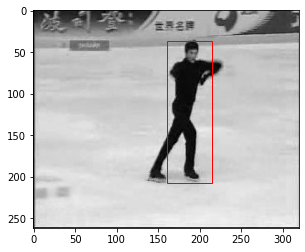

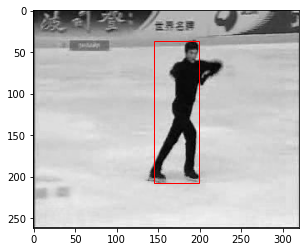

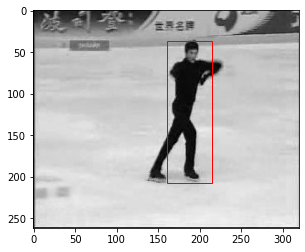

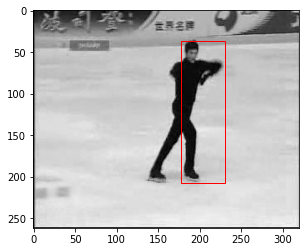

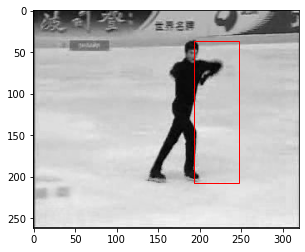

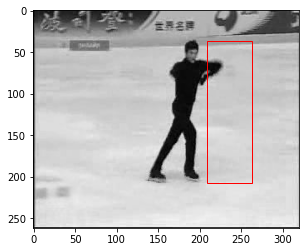

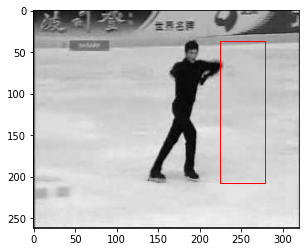

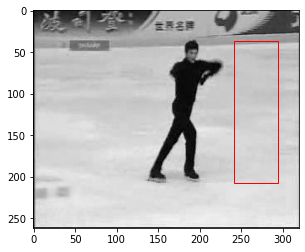

In [ ]:
# HORIZONTAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

img, bbox = TEST_IMAGE, TEST_BBOX
print("Original bounding box")
print(plotNpImageBBox(img, TEST_BBOX))

# Test move left
print("Left-shifted bounding box")
bbox = move(img, TEST_BBOX, "left")
print(plotNpImageBBox(img, bbox))

# Test move right
print("Right-shifted bounding box")
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))

# Test move right
print("Right-shifted bounding box")
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))
bbox = move(img, bbox, "right")
print(plotNpImageBBox(img, bbox))



Original bounding box
[161  37  54 170]
Up-shifted bounding box
[161  37  54 170]
Down-shifted bounding box
[161  88  54 170]


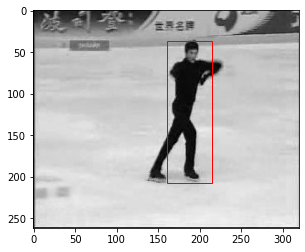

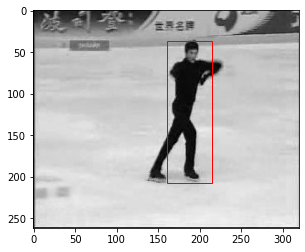

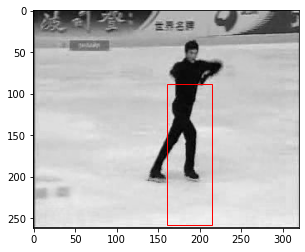

In [ ]:
# VERTICAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

img, bbox = TEST_IMAGE, TEST_BBOX
print("Original bounding box")
print(plotNpImageBBox(img, TEST_BBOX))

# Test move up
print("Up-shifted bounding box")
bbox = move(img, TEST_BBOX, "up")
print(plotNpImageBBox(img, bbox))

# Test move down
print("Down-shifted bounding box")
bbox = move(img, TEST_BBOX, "down")
print(plotNpImageBBox(img, bbox))

[270 194  22  31]


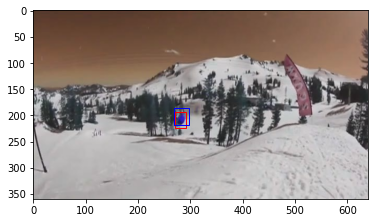

In [39]:

# Update this with the appropriate dataset
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skiing/img/0047.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skiing/groundtruth_rect.txt")[46]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

# Update the following two vars
src_bbox = np.array([269, 185, 29, 33]) 
pred_bbox = np.array([269, 185, 29, 33]) 
print(plotNpImageBBoxes(TEST_IMAGE, TEST_BBOX, my_bbox))

# RL PORTION

In [ ]:
# # Load the data
# DATASET_PATH = "adnet_datasets/OTB/Skater2"

# # 1a) load the images
# filelist = sorted(glob.glob("{0}/img/*".format(DATASET_PATH)))
# images = [cv2.imread(fname) for fname in filelist]
# x = [np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in images]

# # 1b) load the ground truth
# GROUND_TRUTH = "{0}/groundtruth_rect.txt".format(DATASET_PATH)
# gt = get_ground_truths(GROUND_TRUTH)

## ADNET 1

In [48]:
adnet_model=ADNET()

action_hist = np.zeros(shape = (1,1,1,110))
adnet_model.build(action_hist)
#model.compile(tf.keras.optimizers.Adam())
YIFAN_WEIGHTS_PATH = "yifanweights.mat"
weights = hdf5storage.loadmat(YIFAN_WEIGHTS_PATH)
adnet_model=setWeights(adnet_model,weights,weights)

adnet_model.layers[0].trainable=False
adnet_model.layers[1].trainable=False
adnet_model.layers[2].trainable=False
adnet_model.layers[3].trainable=False
adnet_model.layers[4].trainable=False
adnet_model.layers[5].trainable=False

adnet_model.layers[-3].trainable=False

for v in adnet_model.trainable_variables:
  print(v.name)

fc1/kernel:0
fc1/bias:0
fc2/kernel:0
fc2/bias:0
fc3/kernel:0
fc3/bias:0


In [52]:
import tensorflow_probability as tfp
import linecache
import random
import re
from typing import Dict, List
from tensorflow.keras.optimizers import Adam,SGD
from operator import add
import copy

ACTION_DIM = 11
ACTION_HIST = 10 
EPOCH_NO = 10
VERBOSE=False


def train(model: tf.keras.Model, opt: tf.keras.optimizers.Optimizer, 
          dataset: str, L: int=10, K: int= 10, prob_clip: float= 0.995) -> float:
  '''
  :param: dataset: is the dataset path to train from
  :param: L: is the length of the frame sequence to use
  :param: K: is the length of the action history
  TODO: make T configurable?
  :return: returns the average loss
  '''
  # Randomly select sequence of L frames
  
  frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
  number_of_frames = len(frames)
  gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)
  print("Training on dataset: {0} with {1} frames and {2} ground truths"
          .format(dataset, number_of_frames, len(gt)))

  start_frame = random.randint(0, number_of_frames - L - 1) 
  end_frame = start_frame + L  


  with tf.GradientTape() as tape:
    
    bbox = gt[start_frame]
    print("Starting bounding box for {0}: frames {1}:{2} is {3}.".format(
        dataset, start_frame, end_frame, bbox))
    
    seq_losses = []
    
    ######## Frame Sequence Granularity ########
    # FIFO buffer and index
    action_hist, action_hist_idx = np.zeros((ACTION_DIM * K, 1)), 0 
    for i in range(start_frame+1, end_frame):

      img = cv2.imread(frames[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      target_bbox = gt[i]  
      print(">> Training on {0}, img shape:{1}, ".format(
          frames[i], str(img.shape)) 
          +  "Bounding Box: {0}, Target bounding box: {1}".format(
                bbox, target_bbox))    

      ######## Frame Pair Granularity ########
      frame_losses = []
      seen_bboxes = set()     
      for t in range(K):
        print("   |->> t={0}, Bounding box: {1}".format(t, bbox))
        model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
        
        # Get image patch
        patch = tf.image.resize(img[bbox[1]:(bbox[1] + bbox[3]), 
                                    bbox[0]:(bbox[0] + bbox[2])], [112, 112])
        patch = tf.reshape(patch, (1, 112, 112, 3))

        # Call model
        a_prob = tf.reshape(model(patch)[0], (ACTION_DIM)) 
        a, bbox = selectAction(np.array(img), bbox, a_prob) 
        print("      |->> #{0}-th Action selection: {1}"
          .format(t, human_readable_action(a).upper()))
        print("      |->> P(*|s) = {0}".format(np.around(a_prob, decimals=4)))

        # Append REINFORCE loss
        #frame_losses.append(-tf.math.log(a_prob[a]), prob_clip)
        frame_losses.append(-tf.math.log(min(a_prob[a], prob_clip))) #probability clipping
        if isStop(a) or tuple(bbox) in seen_bboxes:
          print("      |->> Hit a STOP on the {0}-th action!".format(t))
          break

        # Prepare for next iteration by setting the action history
        action_hist[action_hist_idx * ACTION_DIM + a] = 1
        action_hist_idx = (action_hist_idx + 1) % ACTION_HIST
        seen_bboxes.add(tuple(bbox))
        # print("      |->> Action History: {0}".format(
        #     action_hist.reshape((10, 11))))

    
      # Scale frame-pair rewards
      iou = calculate_IOU(bbox, target_bbox)
      r = 1 if iou >= 0.7 else -1
      frame_losses = [element * r for element in frame_losses]
      total_frame_loss = sum(frame_losses)
      seq_losses.append(total_frame_loss)
      print(">> Total frame loss: {0}".format(total_frame_loss))


    print("Final bounding box: {0}".format(bbox))
    

  grads = tape.gradient(seq_losses, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  #print([l.get_weights() for l in model.layers[-4:-3]]) # FC WEIGHTs
  return sum([l.numpy().item() for l in seq_losses]) / len(seq_losses)


ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
EPISODES = 100
erroneous_datasets = [] # Use to print problematic dataests

adamOptimizer = Adam(learning_rate=0.001)
sgdOptimizer = SGD(learning_rate=0.00001,momentum=0.9)
losses = []
for i in range(EPISODES):
  print()
  print("################ EPISODE # {0} ################".format(i))

  rand_idx = random.randint(0, len(ALL_DATASETS_LIST) - 1) # INCLUSIVE BOUNDS 
  d = ALL_DATASETS_LIST[rand_idx] 
  try:

    loss = train(adnet_model, adamOptimizer, d, 10, 10)
    losses.append(loss)
  except Exception as e:
    # Catch the exception and move on with training
    print(e)
    erroneous_datasets.append(d)

plt.plot(np.arange(len(losses)), losses) # Plot losses with # episodes

Streaming output truncated to the last 5000 lines.
      |->> P(*|s) = [0.0863 0.0913 0.0903 0.0909 0.0915 0.0931 0.0928 0.0917 0.0889 0.0919
 0.0914]
      |->> Hit a STOP on the 1-th action!
>> Total frame loss: -4.748964786529541
Final bounding box: [203 221  26  31]

################ EPISODE # 78 ################
Training on dataset: adnet_datasets/OTB/Rubik with 1997 frames and 1997 ground truths
Starting bounding box for adnet_datasets/OTB/Rubik: frames 1056:1066 is [262 143 102  82].
>> Training on adnet_datasets/OTB/Rubik/img/1058.jpg, img shape:(480, 640, 3), Bounding Box: [262 143 102  82], Target bounding box: [262 150 102  84]
   |->> t=0, Bounding box: [262 143 102  82]
      |->> #0-th Action selection: 2X LEFT
      |->> P(*|s) = [0.09   0.0916 0.0907 0.0914 0.0913 0.0909 0.0909 0.0912 0.0894 0.0915
 0.0911]
   |->> t=1, Bounding box: [201 143 102  82]
      |->> #1-th Action selection: SCALE DOWN
      |->> P(*|s) = [0.0897 0.0899 0.0903 0.0911 0.0915 0.0903 0.0912 0.09

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-07dc6b53df9d>", line 126, in <module>
    loss = train(adnet_model, adamOptimizer, d, 10, 10)
  File "<ipython-input-52-07dc6b53df9d>", line 50, in train
    img = cv2.imread(frames[i])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, n

KeyboardInterrupt: ignored

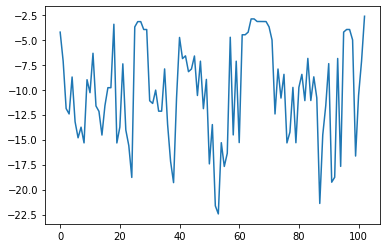

In [55]:
plt.plot(np.arange(len(losses)), losses) # Plot losses with # episodes

## ADNET 2

In [ ]:
model=ADNET_v2()
#action_hist = np.zeros(shape = (1,1,1,110))
action_hist = np.zeros(shape = (1,110))
model.build(action_hist)

In [ ]:
import tensorflow_probability as tfp
import linecache
import random
import re
from typing import Dict, List
from tensorflow.keras.optimizers import Adam,SGD
from operator import add
import copy

ACTION_DIM = 11
ACTION_HIST = 10 
EPOCH_NO = 10
VERBOSE=False


def train(model: tf.keras.Model, dataset: str, L: int=10, K: int= 10):
  '''
  :param: dataset: is the dataset path to train from
  :param: L: is the length of the frame sequence to use
  :param: K: is the length of the action history
  TODO: make T configurable?
  '''
  # Randomly select sequence of L frames
  
  frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
  number_of_frames = len(frames)
  gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)
  print("Training on dataset: {0} with {1} frames and {2} ground truths"
          .format(dataset, number_of_frames, len(gt)))

  start_frame = random.randint(0, number_of_frames - L - 1) 
  end_frame = start_frame + L  

  adamOptimizer = Adam(learning_rate=0.001)
  sgdOptimizer = SGD(learning_rate=0.00001,momentum=0.9)
  with tf.GradientTape() as tape:
    
    bbox = gt[start_frame]
    print("Starting bounding box for {0}: frames {1}:{2} is {3}.".format(
        dataset, start_frame, end_frame, bbox))
    
    seq_losses = []
    seen_bboxes = set()
    action_hist = np.zeros((ACTION_DIM * K, 1)) # FIFO buffer
    action_hist_idx = 0 # FIFO index
    for i in range(start_frame+1, end_frame):
      #print("  >> Training on {}".format(frames[i]))
      img = cv2.imread(frames[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      target_bbox = gt[i]  
      print(">> Training on {0}, img shape:{1}, ".format(
          frames[i], str(img.shape)) 
          +  "Bounding Box: {0}, Target bounding box: {1}".format(
                bbox, target_bbox))    

      frame_losses = []     
      # action_hist = np.zeros((ACTION_DIM * K, 1)) # Between consecutive frames history
      for t in range(K):
        print("   |->> t={0}, Bounding box: {1}".format(t, bbox))
        #model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
        model.setActionHistory(action_hist.reshape((1, ACTION_DIM * K))) ### For ADNET_v2
        
        # Get image patch
        patch = tf.image.resize(img[bbox[1]:(bbox[1] + bbox[3]), 
                                    bbox[0]:(bbox[0] + bbox[2])], [112, 112])
        patch = tf.reshape(patch, (1, 112, 112, 3))

        # Call model
        a_prob = tf.reshape(model(patch)[0], (ACTION_DIM)) 
        a, bbox = selectAction(np.array(img), bbox, a_prob) 
        print("      |->> #{0}-th Action selection: {1} with P(a|s)= {2}"
          .format(t,human_readable_action(a).upper(), a_prob[a]))
        
        # Append REINFORCE loss
        frame_losses.append(-tf.math.log(a_prob[a]))
        #frame_losses.append(-tf.math.log(min(a_prob[a],0.9))) #probability clipping
        if isStop(a) or tuple(bbox) in seen_bboxes:
          print("      |->> Hit a STOP!")
          break

        # Prepare for next iteration by setting the action history
        
        action_hist[action_hist_idx * ACTION_DIM + a] = 1
        action_hist_idx = (action_hist_idx + 1) % ACTION_HIST
        # action_hist[t * ACTION_DIM + a] = 1 
        seen_bboxes.add(tuple(bbox))
        # print("    > Action History: {0}".format(action_hist.reshape((10, 11))))

    
      # After the K sequence, how close are we to the target?
      iou = calculate_IOU(bbox, target_bbox)
      r = 1 if iou >= 0.7 else -1
      frame_losses = [element * r for element in frame_losses]
      seq_losses.append(tf.reshape(sum(frame_losses), (1)))

    
    print("Sequence Losses: {0}".format(
        [l.numpy().item() for l in seq_losses])) 

  grads = tape.gradient(tf.reshape(sum(seq_losses), (1)),model.trainable_variables)
  sgdOptimizer.apply_gradients(zip(grads, model.trainable_variables))
    #print([l.get_weights() for l in model.layers[-4:-3]]) # FC WEIGHTs


ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
erroneous_datasets = [] # Use to print problematic dataests
for i in range(10):

  rand_idx = random.randint(0, len(ALL_DATASETS_LIST) - 1) # INCLUSIVE BOUNDS 
  d = ALL_DATASETS_LIST[rand_idx] 
  try:
    train(model, d, 10, 10)
  except Exception as e:
    # Catch the exception and move on with training
    print(e)
    erroneous_datasets.append(d)

# Prediction

In [ ]:
print(erroneous_datasets)

# !ls adnet_datasets/OTB/Diving/img/
# ! wc -l adnet_datasets/OTB/Diving/groundtruth_rect.txt

['adnet_datasets/OTB/Diving']


In [ ]:
def predict(model: tf.keras.Model,img: np.array,bbox: np.array) -> np.array:
  ACTION_DIM=11
  K=10
  
  action_hist = np.zeros((ACTION_DIM * K, 1))
  seen_bboxes = set()
  for t in range(K):
    #model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
    model.setActionHistory(action_hist.reshape((1,ACTION_DIM * K))) ### For ADNET_v2
    patch = tf.image.resize(img[bbox[1]:(bbox[1] + bbox[3]), 
                                bbox[0]:(bbox[0] + bbox[2])], [112, 112])
    patch = tf.reshape(patch, (1, 112, 112, 3))
    a_prob = tf.reshape(model(patch)[0], (ACTION_DIM)) 
    a, bbox = selectAction(np.array(img), bbox, a_prob)
    if isStop(a) or tuple(bbox) in seen_bboxes:
      break

    action_hist[t * ACTION_DIM + a] = 1 
    seen_bboxes.add(tuple(bbox))
  return bbox

In [ ]:
def plotNpImageBBoxGT(img: np.array, bbox: np.array,gbbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x_pre,y_pre, w_pre, h_pre = bbox
  x_gr,y_gr, w_gr, h_gr = gbbox
  predicted_rect = patches.Rectangle((x_pre, y_pre), w_pre, h_pre, linewidth=1, edgecolor='r', facecolor='none')
  gt_rect = patches.Rectangle((x_gr, y_gr), w_gr, h_gr, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(predicted_rect)
  ax.add_patch(gt_rect)
  plt.imshow(img)
  return bbox

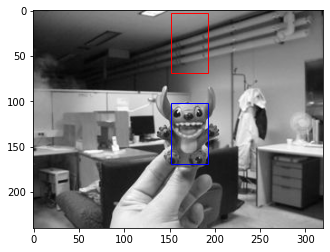

In [ ]:
ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
j = random.randint(0, len(ALL_DATASETS_LIST)) 
dataset = ALL_DATASETS_LIST[j] 
frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)

predicted_bbox = gt[0]
for i, frame in enumerate(frames[1:]):
  img = cv2.imread(frame)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  predicted_bbox=predict(model,img,predicted_bbox)
  gtbbox=gt[i]
  plotNpImageBBoxGT(img,predicted_bbox,gtbbox)
  #print(gtbbox)
  #print(predicted_bbox)
  break
  #bbox = 
  #print(model)

# SCRATCH

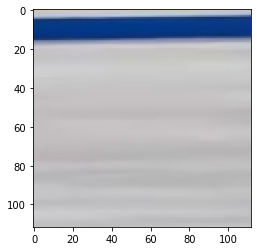

[[[[nan nan nan nan nan nan nan nan nan nan nan]]]]


In [ ]:
# action_hist = np.zeros((110, 1)) # 110 x 1 vector
# model.setActionHistory(action_hist.reshape((1, 1, 1, 110)))
# img,imgModel,re=cropImage(x[0],[100,40,50,140])
# plt.imshow(re)
# plt.show()
# patch = tf.reshape(imgModel, (1, 112, 112, 3))
# a_prob = model.call(patch)[0]
# print(np.array(a_prob))
# em1=model.getEmbedding(patch)
# f1=model.getFC1(patch)

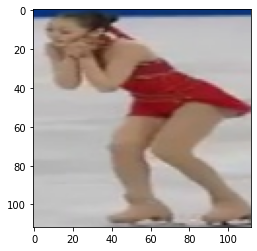

[[[[0.09048285 0.09075713 0.09066235 0.09107865 0.09114216 0.09088685
    0.09094688 0.09094015 0.09107637 0.09087441 0.09115221]]]]


In [ ]:
action_hist = np.zeros((110, 1)) # 110 x 1 vector
model.setActionHistory(action_hist.reshape((1, 1, 1, 110)))
img,imgModel,re=cropImage(x[0],bbox[0])
plt.imshow(re)
plt.show()
patch = tf.reshape(imgModel, (1, 112, 112, 3))
a_prob = model.call(patch)[0]
print(np.array(a_prob))
em2=model.getEmbedding(patch)
f2=model.getFC1(patch)

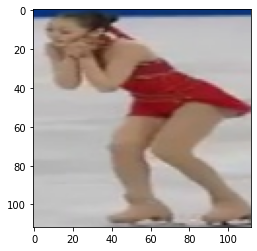

[[[0.09091367]]]
8


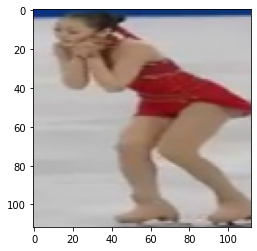

[[[0.09091367]]]
8


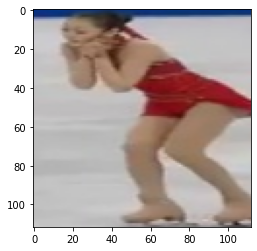

[[[0.09091367]]]
8


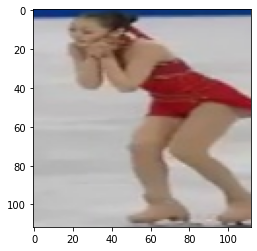

[[[0.09091367]]]
8


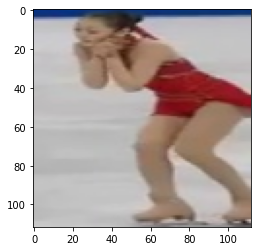

[[[0.09091367]]]
8


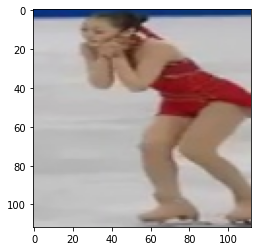

[[[0.09091367]]]
8


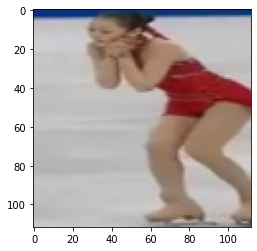

[[[0.09091367]]]
8


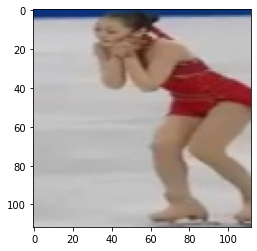

[[[0.09091367]]]
8


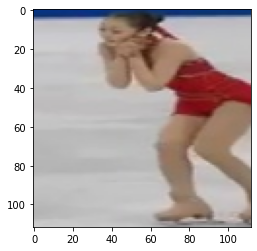

[[[0.09091367]]]
8


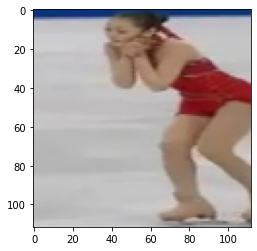

[[[0.09091367]]]
8


In [ ]:
arr=[]
from matplotlib.pyplot import imshow, show    
for i in range(10):
  img,imgModel,re=cropImage(x[0],bbox[i])
  imshow(re)
  show()
  arr.append(imgModel)
  patch = tf.reshape(imgModel, (1, 112, 112, 3))
  a_prob = model.call(patch)[0]
  a, newbbox = selectAction(a_prob, newbbox, np.array(img)) 
  print(np.array(a_prob)[:,:,:,8])
  print(a)